El tiempo de ejecución del siguiente notebook es aproximadamente 30 minutos.

# 0.- Importación librerías

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd

#Generación Variables : Distancia haversine
import math
from   math import radians, sin, cos, sqrt, atan2

# para dibujar
import matplotlib.pyplot as plt 
%matplotlib inline

#Modelos
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn import linear_model #Modelo Lineal
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


#StandardScaler
from sklearn.preprocessing import scale 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


#graphviz
import graphviz


# Para mostrar todas las columnas y filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Preparación de datos: División train/test

In [2]:
from sklearn.model_selection import train_test_split

airbnb_pd = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')
train, test = train_test_split(airbnb_pd, test_size=0.3, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y test PERO trabajamos ÚNICAMENTE con el de train. 
df_train = pd.read_csv('./train.csv', sep=';', decimal='.')
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (10346, 89)
Dimensiones del dataset de test: (4434, 89)


# 2. Análisis exploratorio

## Funciones auxliares

In [3]:
#Funcion para mostrar columnas por su tipo ( numéricas y no numéricas)
def tipo_columnas(df):
    """Información sobre columnas numéricas y no numéricas de un dataframe. 
 
	Parámetros:
	df -- dataframe
    
	Returns:
	num --  array con columnas numéricas('int','float')
	not_num -- array con columnas no numéricas.
	"""
    columnas_numericas = df.select_dtypes(include=['int', 'float']).columns
    print(f"Columnas numéricas: {len(columnas_numericas)} columnas.")
    print(', '.join(columnas_numericas))
    # Obtener las columnas de tipo no numérico
    columnas_no_numericas = df.select_dtypes(exclude=['int', 'float']).columns
    print(f"Columnas no númericas: {len(columnas_no_numericas)} columnas.")
    print(', '.join(columnas_no_numericas))
    return columnas_numericas , columnas_no_numericas 

num , not_num = tipo_columnas(df_train)

Columnas numéricas: 36 columnas.
ID, Scrape ID, Host ID, Host Response Rate, Host Listings Count, Host Total Listings Count, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Price, Weekly Price, Monthly Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Availability 30, Availability 60, Availability 90, Availability 365, Number of Reviews, Review Scores Rating, Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Location, Review Scores Value, Calculated host listings count, Reviews per Month
Columnas no númericas: 53 columnas.
Listing Url, Last Scraped, Name, Summary, Space, Description, Experiences Offered, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host URL, Host Name, Host Since, Host Location, Host About, Host Response Time, Host Acceptance Rate, Host Thumbn

## Head

In [4]:
df_train.head(5).T 

,0,1,2,3,4
ID,2156319,3377153,14800635,11185674,18092171
Listing Url,https://www.airbnb.com/rooms/2156319,https://www.airbnb.com/rooms/3377153,https://www.airbnb.com/rooms/14800635,https://www.airbnb.com/rooms/11185674,https://www.airbnb.com/rooms/18092171
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,GRANT VII Plaza Mayor,Nice flat in Plaza Mayor (lift),* ROOM double Barrio Salamanca *,cheap apartment in Madrid city cent,"ACOGEDOR APARTAMENTO EN MADRID, CALLE MANZANARES"
Summary,NaN,"Flat is in the centre town, really close to Pl...","Private room for two persons has a double bed,...","Cheap apartment, next to Madrid rio, just four...","Acogedor apartamento, para parejas y/o familia."
Space,Beautiful and charming apartment recently deco...,You cannot find a better location to stay in M...,It is a penthouse located in the salamanca dis...,NaN,NaN
Description,Beautiful and charming apartment recently deco...,"Flat is in the centre town, really close to Pl...","Private room for two persons has a double bed,...","Cheap apartment, next to Madrid rio, just four...","Acogedor apartamento, para parejas y/o familia."
Experiences Offered,none,none,none,none,none
Neighborhood Overview,NaN,"It´s really cool, with a lot of new business (...",The District of Salamanca is one of the 21 dis...,NaN,NaN


In [5]:
print(f"El train del dataset tiene {df_train.shape[0]} entradas y {df_train.shape[1]} características/variables ")

El train del dataset tiene 10346 entradas y 89 características/variables 


## Describe

In [6]:
df_train.describe()

,ID,Scrape ID,Host ID,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
count,1.034600e+04,1.034600e+04,1.034600e+04,9016.000000,10344.000000,10344.000000,10346.000000,10346.000000,10346.000000,10308.000000,10326.000000,10312.000000,410.000000,10332.000000,2513.000000,2502.000000,4447.000000,6124.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.00000,10346.000000,10346.000000,10346.000000,7995.000000,7976.000000,7980.000000,7971.000000,7980.000000,7969.000000,7967.000000,10342.000000,8100.000000
mean,1.028354e+07,2.017038e+13,3.606270e+07,94.846273,12.876450,12.876450,40.485115,-3.708535,3.290064,1.289726,1.347376,2.053627,395.139024,74.242935,380.284123,1441.808153,188.551158,32.268452,1.586797,7.641601,3.148560,979.637444,8.979702,22.99913,39.838972,201.677170,22.453412,91.607380,9.411234,9.319799,9.619621,9.643609,9.535073,9.208736,9.658963,1.871260
std,5.555731e+06,5.374658e+08,3.417818e+07,15.124996,34.990589,34.990589,4.673811,13.720947,2.096108,0.668635,0.904172,1.626308,667.520462,72.418780,195.799471,1265.861086,115.648243,31.545209,1.163591,11.662596,14.211265,10033.724779,9.358143,19.80569,29.735404,128.242731,37.736055,9.121333,0.932933,1.003058,0.810896,0.769159,0.776672,0.960288,23.879225,1.873803
min,1.986400e+04,2.016010e+13,1.745300e+04,0.000000,0.000000,0.000000,-37.851182,-122.437371,1.000000,0.000000,0.000000,1.000000,0.000000,9.000000,70.000000,250.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000
25%,5.597253e+06,2.017041e+13,6.884224e+06,100.000000,1.000000,1.000000,40.409782,-3.707615,2.000000,1.000000,1.000000,1.000000,0.000000,35.000000,220.000000,750.000000,100.000000,15.000000,1.000000,0.000000,1.000000,365.000000,0.000000,4.00000,11.000000,77.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.450000
50%,1.130555e+07,2.017041e+13,2.483964e+07,100.000000,2.000000,2.000000,40.419343,-3.700787,3.000000,1.000000,1.000000,2.000000,86.000000,57.000000,350.000000,1250.000000,150.000000,25.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,20.00000,38.000000,238.000000,7.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.190000
75%,1.532606e+07,2.017041e+13,5.431096e+07,100.000000,6.000000,6.000000,40.430789,-3.684274,4.000000,1.000000,2.000000,2.000000,646.000000,88.250000,500.000000,1750.000000,200.000000,40.000000,2.000000,15.000000,3.000000,1125.000000,14.000000,38.00000,65.000000,319.000000,27.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.790000
max,1.858361e+07,2.017062e+13,1.247534e+08,100.000000,519.000000,519.000000,55.945755,153.371427,16.000000,8.000000,10.000000,16.000000,6997.000000,969.000000,999.000000,25000.000000,990.000000,662.000000,16.000000,276.000000,1125.000000,1000000.000000,30.000000,60.00000,90.000000,365.000000,339.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,145.000000,17.210000


## Dtypes

In [7]:
df_train.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

## Info

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10346 non-null  int64  
 1   Listing Url                     10346 non-null  object 
 2   Scrape ID                       10346 non-null  int64  
 3   Last Scraped                    10346 non-null  object 
 4   Name                            10345 non-null  object 
 5   Summary                         9922 non-null   object 
 6   Space                           7619 non-null   object 
 7   Description                     10340 non-null  object 
 8   Experiences Offered             10346 non-null  object 
 9   Neighborhood Overview           6397 non-null   object 
 10  Notes                           3960 non-null   object 
 11  Transit                         6327 non-null   object 
 12  Access                          

## Correlación

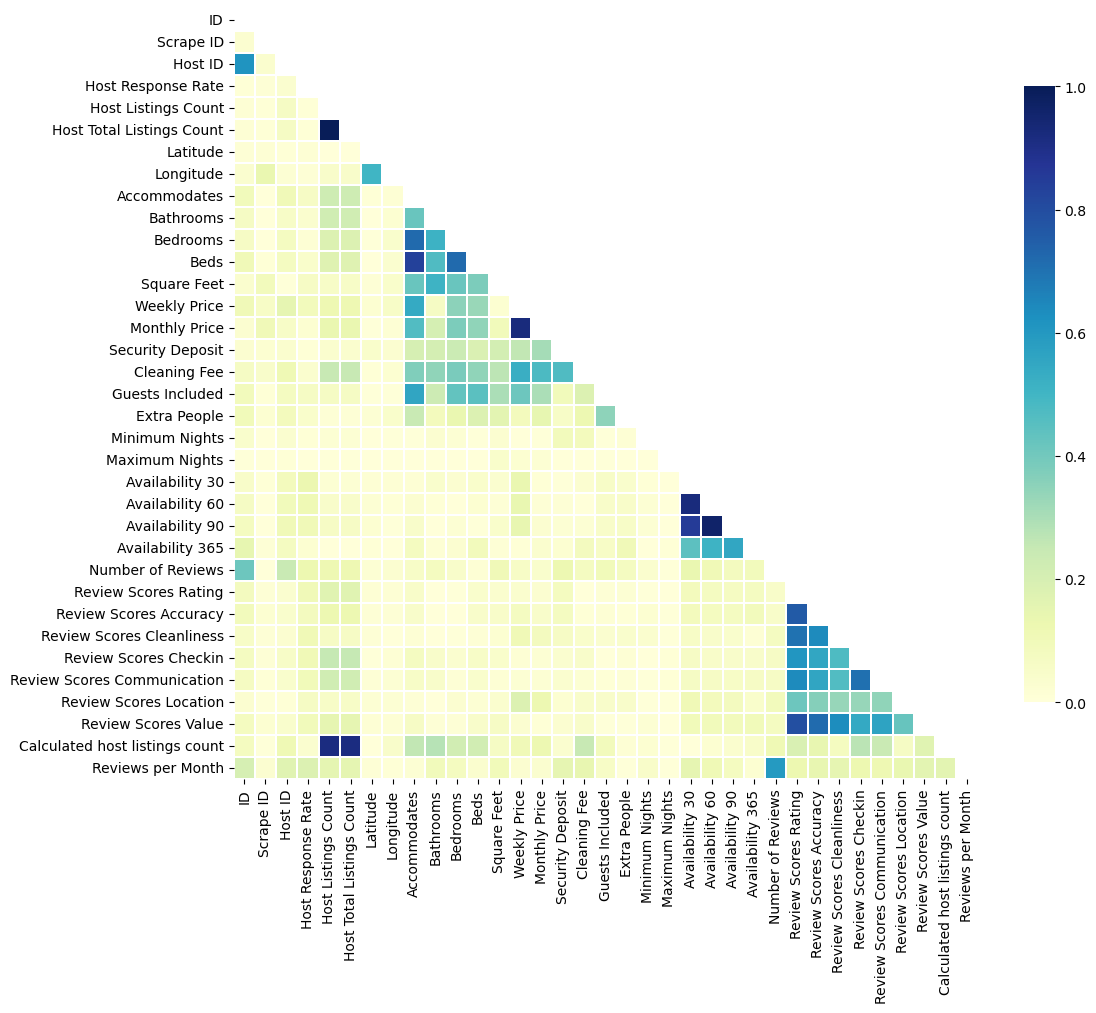

In [9]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train[num].drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# 3. Preprocesamiento

In [10]:
#Para que los algoritmos de selección de características funcionen tenemos que imputar los Nan. Lo haremos con la media.
df_train_prepoc = df_train[num].fillna(df_train[num].mean())

features = df_train_prepoc[num].columns.drop(['Price'])
X_train = df_train_prepoc[features].values
y_train = df_train_prepoc['Price'].values

#Escalamos 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

print(X_train.shape)
print(y_train.shape)

(10346, 35)
(10346,)


##  A. Eliminación de variables

### Selección variables / Feature Selection

#### Random Forest selección de variables

Fitting 3 folds for each of 19 candidates, totalling 57 fits
best mean cross-validation score: 0.654
best parameters: {'max_depth': 19}


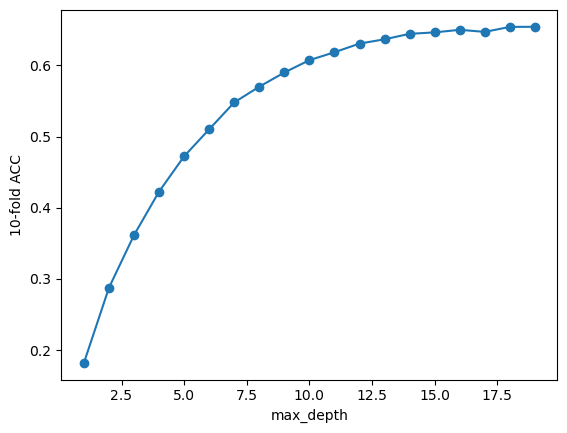

In [11]:
from sklearn.ensemble import RandomForestRegressor

# grid search
maxDepth = range(1,20)
n_estimators = [100, 200, 300, 500, 1000, 1500, 2000]
#tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estimators}
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=3, verbose=1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [12]:
maxDepthOptimo = grid.best_params_['max_depth']
rf = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train) # bajamos porque tiene pinta de overfitting

print("Train: ",rf.score(X_train,y_train))

Train:  0.9327511553746523


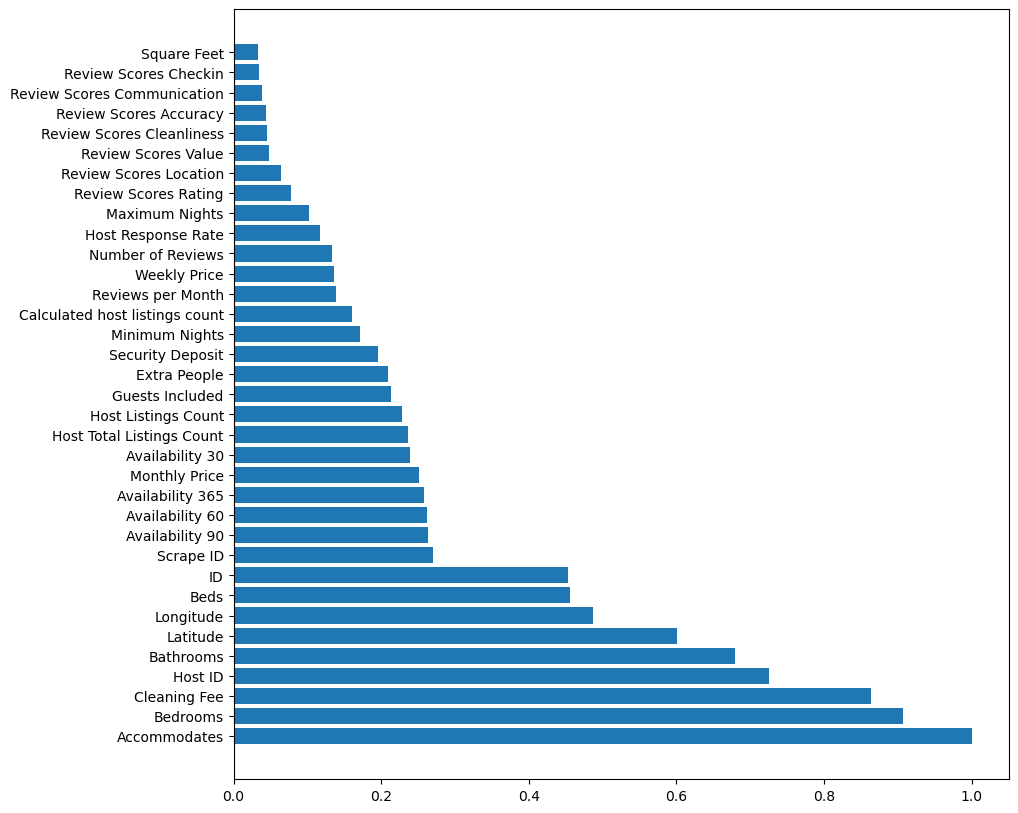

In [13]:
importances = rf.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

In [14]:
n_variables = 20
print(f"Las {n_variables} más importantes por el método Random Forest son : {', '.join(str(columna) for columna in features[:n_variables])}")

Las 20 más importantes por el método Random Forest son : ID, Scrape ID, Host ID, Host Response Rate, Host Listings Count, Host Total Listings Count, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Weekly Price, Monthly Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights


#### Filtrado

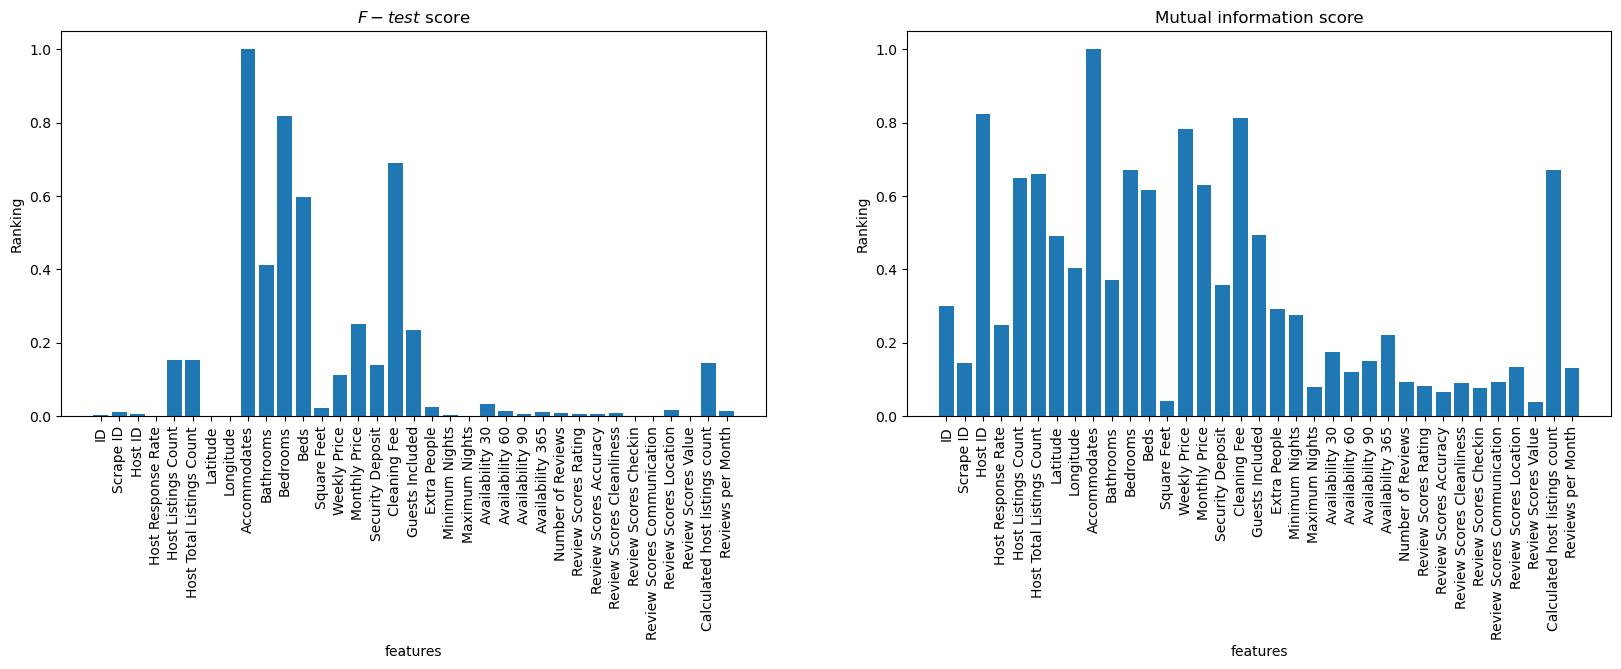

In [15]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# do calculations
f_test, _ = f_regression(X_train,y_train)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_train,y_train)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),features, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')

plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi, align="center")
plt.xticks(range(X_train.shape[1]),features, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

#### Lasso

best mean cross-validation score: -2935.712
best parameters: {'alpha': 0.12689610031679222}


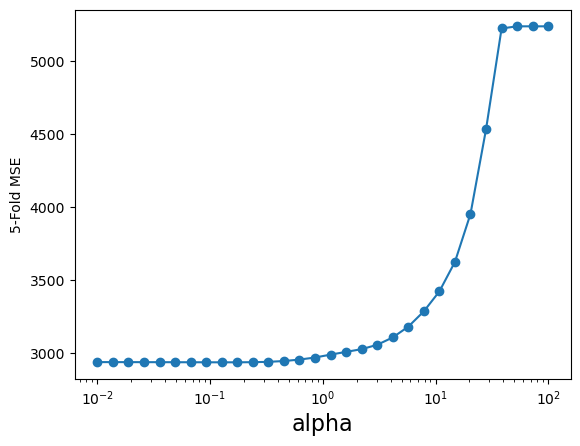

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-2,2,30)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 3)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train,y_train)

ytrainLasso = lasso.predict(X_train)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)


print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 2.85e+03
RMSE Modelo Lasso (train): 53.4
ID -0.5730115134863453
Scrape ID -2.659536360128427
Host ID 1.3108476648313303
Host Response Rate -0.39721542429707307
Host Listings Count 10.90295356124801
Host Total Listings Count 0.0
Latitude -0.6868106271856569
Longitude -0.0
Accommodates 27.757502277738542
Bathrooms 7.0367163456583075
Bedrooms 9.015230696139609
Beds -9.592275765269049
Square Feet 2.195408476836307
Weekly Price 2.1663976311945463
Monthly Price 9.285494401480317
Security Deposit 4.492902992054834
Cleaning Fee 18.500359084545387
Guests Included 0.17639414544230053
Extra People -3.47933460730545
Minimum Nights -0.1404817289707677
Maximum Nights 0.0
Availability 30 12.785170868889086
Availability 60 -0.0
Availability 90 -4.656286134458322
Availability 365 -0.7061033068587717
Number of Reviews -0.3698459370677302
Review Scores Rating 3.3841372325215393
Review Scores Accuracy 0.8338419042144513
Review Scores Cleanliness 1.3413365366754053
Review Scores C

#### GradientBoostingClassifier

In [18]:
Niterations = [100,250,500,1000]
learningRate = [0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid_GradientBoostingRegressor = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 2, verbose=1)
grid_GradientBoostingRegressor.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_GradientBoostingRegressor.best_score_))
print("best parameters: {}".format(grid_GradientBoostingRegressor.best_params_))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
best mean cross-validation score: 0.606
best parameters: {'learning_rate': 0.1, 'n_estimators': 1000}


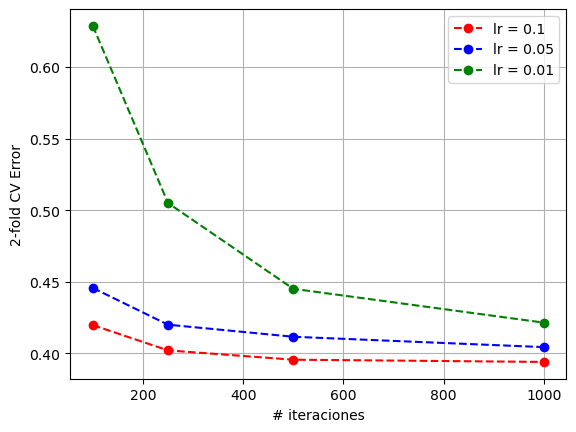

In [19]:
lrOptimo = grid_GradientBoostingRegressor.best_params_['learning_rate']
neOptimo = grid_GradientBoostingRegressor.best_params_['n_estimators']
GradientBoostingRegressor_bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
GradientBoostingRegressor_bt.fit(X_train,y_train)

error_GradientBoostingRegressor_bt = 1-grid_GradientBoostingRegressor.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error_GradientBoostingRegressor_bt[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('2-fold CV Error')
plt.grid()
plt.show()

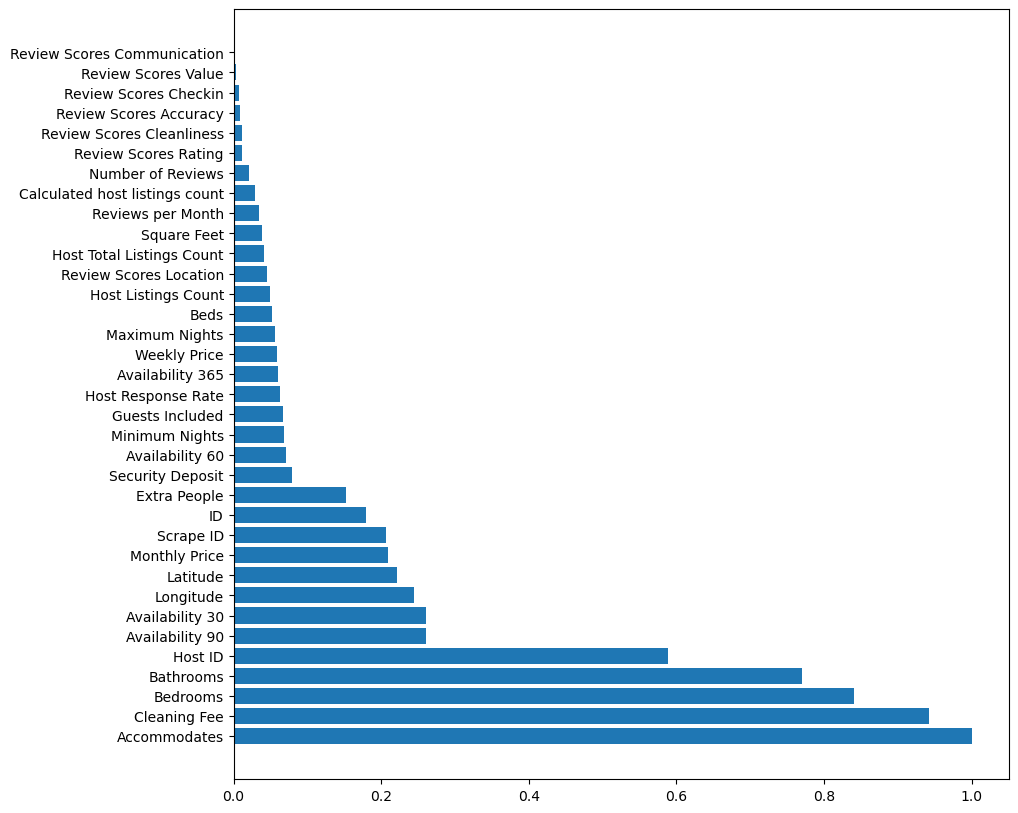

In [20]:
importances = GradientBoostingRegressor_bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

In [21]:
n_variables = 20
print(f"Las {n_variables} más importantes por el método Random Forest son : {', '.join(str(columna) for columna in features[:n_variables])}")

Las 20 más importantes por el método Random Forest son : ID, Scrape ID, Host ID, Host Response Rate, Host Listings Count, Host Total Listings Count, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Weekly Price, Monthly Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights


### Outliers

#### Price

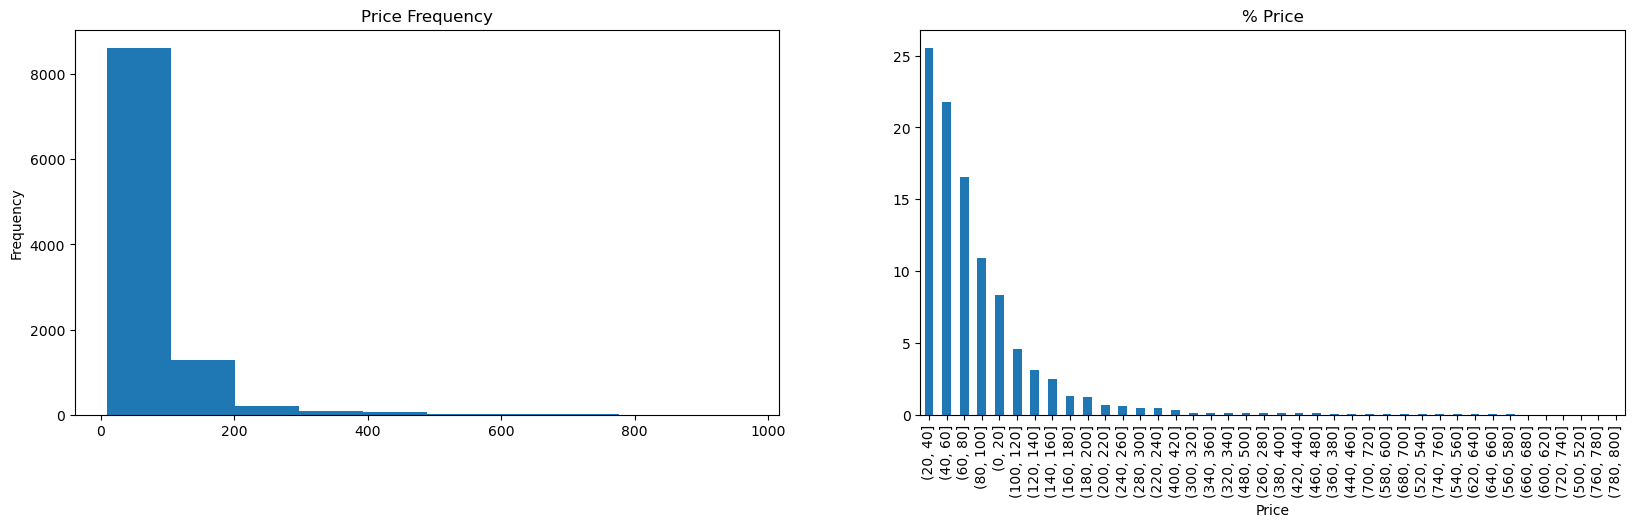

La mayoría de los precios oscilan entre 20 y 100 euros. Nos quedaremos con las entradas que tengan el precio en dicha orquilla


In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
df_train['Price'].plot.hist(title='Price Frequency')
plt.subplot(1,2, 2)
(100 * pd.cut(df_train['Price'], bins=[x for x in range(0, 801, 20)]).value_counts() / len(df_train['Price'])).plot(kind='bar', title='% Price')
plt.show()
print("La mayoría de los precios oscilan entre 20 y 100 euros. Nos quedaremos con las entradas que tengan el precio en dicha orquilla") 

#### Property Type

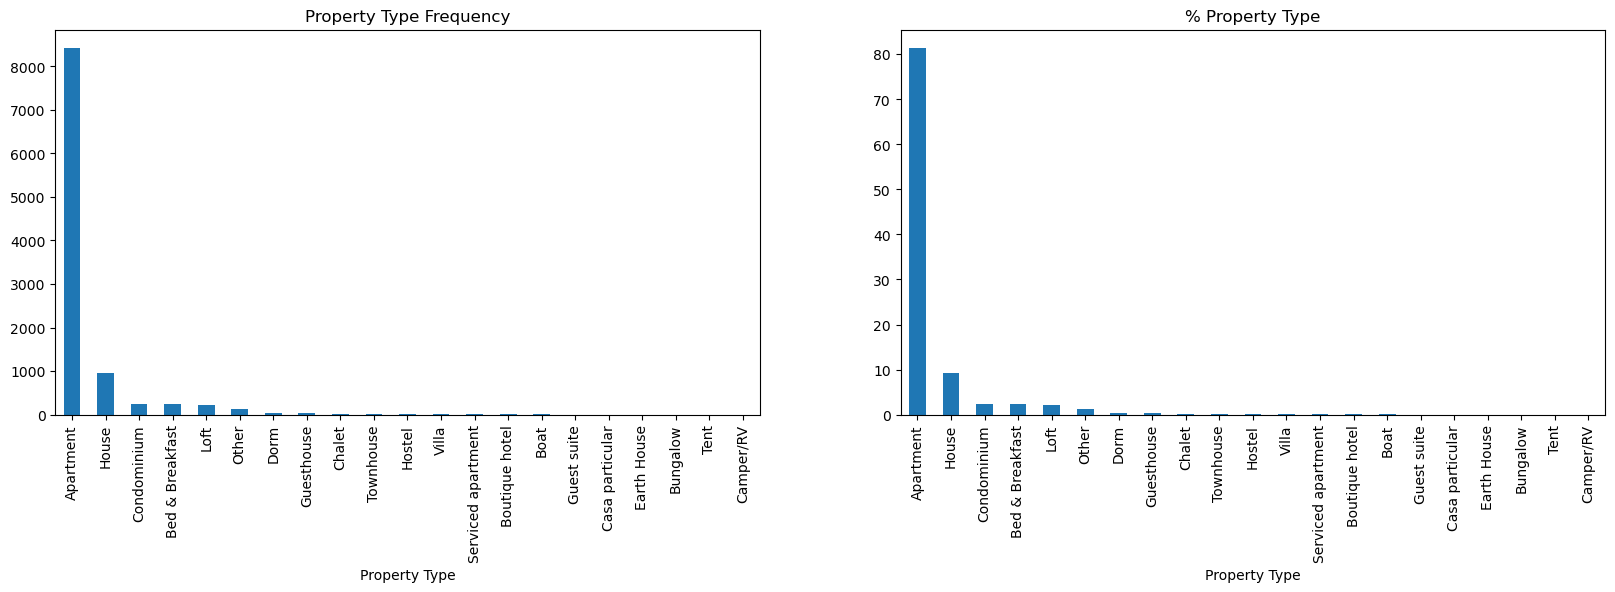

Más del 80% de los tipos de propiedad son Apartment. Nos quedaremos con sólo esos tipos de propiedad


In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
df_train['Property Type'].value_counts().plot(kind='bar',title='Property Type Frequency')

plt.subplot(1,2, 2)
(100 * df_train['Property Type'].value_counts() / len(df_train['Property Type'])).plot(kind='bar', title='% Property Type')
plt.show()
print("Más del 80% de los tipos de propiedad son Apartment. Nos quedaremos con sólo esos tipos de propiedad")

In [24]:
df_train['Property Type'].value_counts()

Property Type
Apartment             8422
House                  955
Condominium            244
Bed & Breakfast        236
Loft                   212
Other                  140
Dorm                    31
Guesthouse              27
Chalet                  17
Townhouse               14
Hostel                  11
Villa                   11
Serviced apartment       9
Boutique hotel           4
Boat                     3
Guest suite              2
Casa particular          2
Earth House              2
Bungalow                 2
Tent                     1
Camper/RV                1
Name: count, dtype: int64

### Amenities

In [25]:
lsls = []
for index , fila in df_train.dropna(subset=['Amenities']).iterrows():
    feature = fila["Amenities"].split(",")
    for f in feature:
        if f not in lsls:
    	    lsls.append(f)

for com in lsls:
    print(f"{com} : {df_train['Amenities'].str.contains(com).sum()}")
    
print("\n\n No hay ninguna variable que nos de información suficientemente importante para generar una variable nueva")

TV : 8144
Internet : 9800
Wireless Internet : 9710
Air conditioning : 5624
Wheelchair accessible : 1059
Smoking allowed : 2672
Pets allowed : 1766
Doorman : 1938
Elevator in building : 6018
Buzzer/wireless intercom : 4587
Heating : 9317
Family/kid friendly : 6243
Suitable for events : 500
Washer : 8761
Essentials : 8868
Kitchen : 9524
Smoke detector : 1774
Carbon monoxide detector : 1209
Shampoo : 6385
24-hour check-in : 2523
Hangers : 6791
Hair dryer : 5742
Iron : 5906
Laptop friendly workspace : 5210
translation missing: en.hosting_amenity_50 : 2998
First aid kit : 2675
Lock on bedroom door : 920
Safety card : 1048
Fire extinguisher : 1788
Cable TV : 1245
Pool : 640
Breakfast : 1536
Pets live on this property : 604
translation missing: en.hosting_amenity_49 : 2350
Gym : 230
Indoor fireplace : 407
Dryer : 2005
Private entrance : 313
Free parking on premises : 918
Hot tub : 299
Cat(s) : 0
Self Check-In : 254
Doorman Entry : 154
Dog(s) : 0
Private living room : 187
Crib : 20
Lockbox : 6

C:\Users\Bart\AppData\Local\Temp\ipykernel_18684\3252137269.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print(f"{com} : {df_train['Amenities'].str.contains(com).sum()}")


Elevator in Building : 6
Stair gates : 4
Children’s dinnerware : 9
Babysitter recommendations : 6
Game console : 6
Pets Allowed : 4
Carbon Monoxide Detector : 14
Safety Card : 8
Fire Extinguisher : 8
24-Hour Check-in : 9
Hair Dryer : 18
Laptop Friendly Workspace : 14
Window guards : 11
Hot water : 1
Bed linens : 1
Extra pillows and blankets : 1
Microwave : 1
Coffee maker : 1
Refrigerator : 1
Dishwasher : 1
Dishes and silverware : 1
Cooking basics : 1
Oven : 1
Patio or balcony : 1
Garden or backyard : 1
Luggage dropoff allowed : 1
Long term stays allowed : 1
Path to entrance lit at night : 1
Buzzer/Wireless Intercom : 4
Other pet(s) : 0
Smartlock : 19
Air Conditioning : 5
Pack ’n Play/travel crib : 14
Paid parking off premises : 3
Lock on Bedroom Door : 4
Free parking on street : 5
Washer / Dryer : 2
Hot Tub : 1
Wheelchair Accessible : 1


 No hay ninguna variable que nos de información suficientemente importante para generar una variable nueva


### Ciudad

In [26]:
unique_locations = df_train["City"].unique().astype(str)
for location in np.sort(unique_locations):
    print(location+" "+str(df_train[df_train["City"]==location].shape[0]))
print(len(unique_locations))
print("\n\n")
print("Se puede observar que la mayoría de los pisos se encuentras en Madrid nos quedaremos con los pisos que estén en Madrid ")

Alaró 5
Alcudia 1
Alcúdia 29
Algaida 2
Amsterdam 16
Andratx 1
Antwerpen 2
Aravaca (Madrid) 1
Ariany 1
Athens 1
Athina 2
Austin 3
Balearic Islands 4
Ballsbridge 1
Barcelona 211
Berlin 29
Berlín 1
Betlem 1
Beverly Hills 1
Biniamar 1
Binissalem 1
Boadilla del Monte 1
Bondi 2
Bondi Beach 8
Bondi Junction 1
Boston 1
Brent 1
Bronx 1
Brooklyn 18
Brunswick 1
Brussel 1
Bruxelles 3
Bunyola 1
Búger 7
Caimari 1
Cala Agulla 1
Cala Anguila-Cala Mendia 1
Cala Ferrera 2
Cala Magrana 1
Cala Murada 1
Cala Pi 2
Cala Ratjada 1
Calvià 2
Campanet 4
Campos 2
Can Pastilla 3
Can Picafort 4
Centro 1
Chicago 6
Chueca 1
Chueca, Madrid 1
Clongriffin 2
Cologny 1
Colonia Sant Pere 1
Colònia de Sant Jordi 2
Copenhagen 4
Costa dels Pins 1
Costitx 1
Deià 6
Delicias 1
Denver 1
Deyá 1
Dorroughby 1
Dublin 18
Edimburgo 1
Edinburgh 4
El Toro 1
Felanitx 4
Font de Sa Cala 1
Footscray 1
Forest 1
Forest Lodge 1
Frederiksberg C 1
Genève 2
Ginebra 1
Greater London 2
Hong Kong 1
Hospitalet de Llobregat 1
Illes Balears 1
Illetes 1


### Room Type

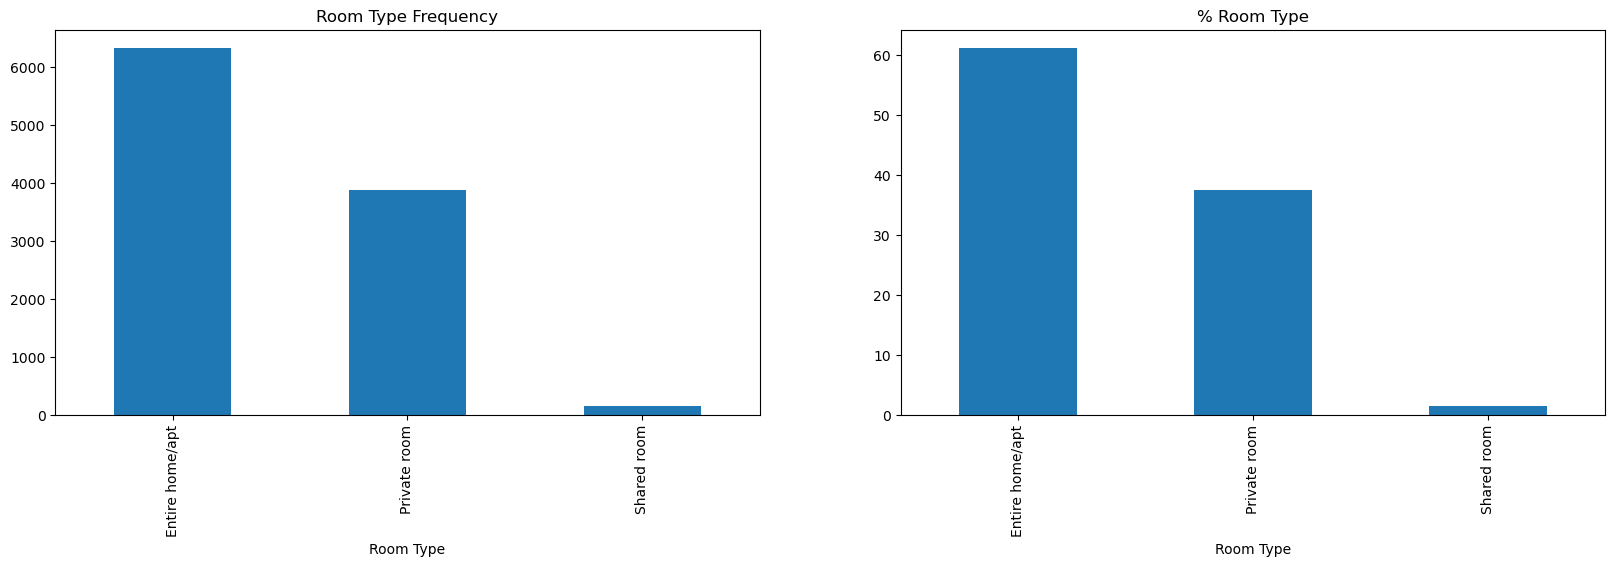

El 95% de los tipos de habitación son Entire home/apt o Private Room. Nos quedaremos con sólo esos tipos de habitaciones


In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
df_train['Room Type'].value_counts().plot(kind='bar',title='Room Type Frequency')

plt.subplot(1,2, 2)
(100 * df_train['Room Type'].value_counts() / len(df_train['Room Type'])).plot(kind='bar', title='% Room Type')
plt.show()

print("El 95% de los tipos de habitación son Entire home/apt o Private Room. Nos quedaremos con sólo esos tipos de habitaciones")

### Bed type

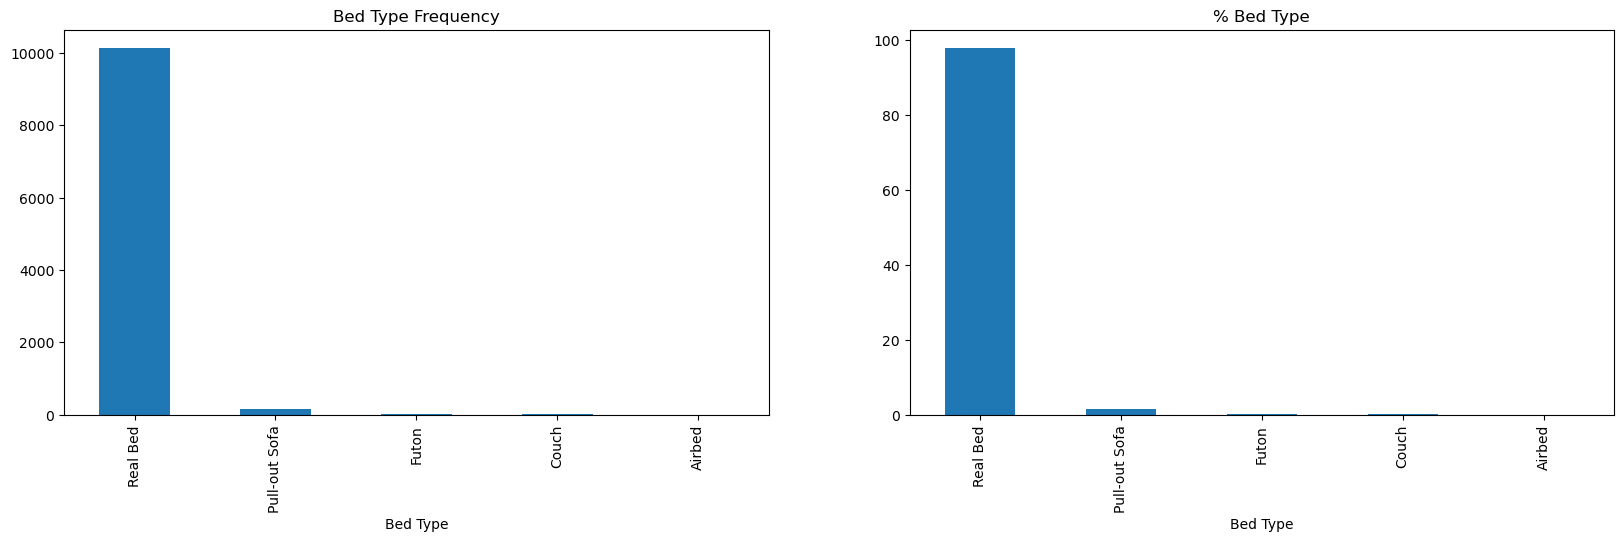

Nos quedamos con Bed type real bed que son casi el 100%


In [28]:
plt.figure(figsize=(20,5))
plt.subplot(1,2, 1)
df_train['Bed Type'].value_counts().plot(kind='bar',title='Bed Type Frequency')

plt.subplot(1,2, 2)
(100 * df_train['Bed Type'].value_counts() / len(df_train['Bed Type'])).plot(kind='bar', title='% Bed Type')
plt.show()

print("Nos quedamos con Bed type real bed que son casi el 100%")

### Características con gran porcentaje de nulos

In [29]:
print("Quitamos aquellas características que tiene un 75% o más de valores nulos\n\n")
print((df_train.isnull().sum().sort_values(ascending=False)/df_train.shape[0])*100)

Quitamos aquellas características que tiene un 75% o más de valores nulos


Has Availability                  99.932341
Host Acceptance Rate              99.758361
Jurisdiction Names                98.617823
License                           97.573942
Square Feet                       96.037116
Monthly Price                     75.816741
Weekly Price                      75.710419
Notes                             61.724338
Security Deposit                  57.017205
Interaction                       44.451962
Access                            43.804369
Cleaning Fee                      40.808042
Transit                           38.845931
Neighborhood Overview             38.169341
Host About                        35.317997
Neighbourhood                     35.182679
House Rules                       34.873381
Space                             26.358013
Host Neighbourhood                25.913396
Review Scores Value               22.994394
Review Scores Location            22.975063


### Alta correlación

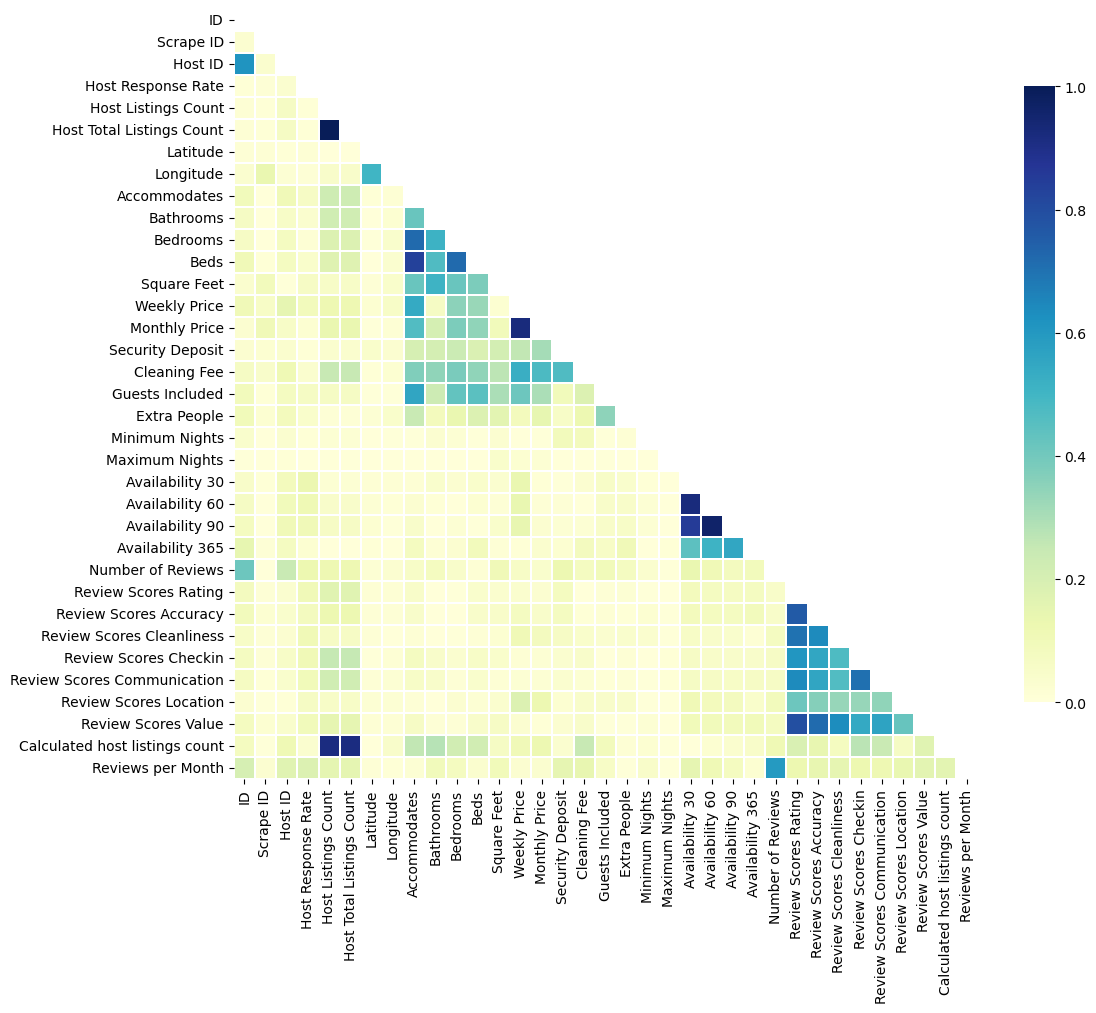

In [30]:
# Compute the correlation matrix
corr = np.abs(df_train[num].drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [31]:
df_train[num].corr(numeric_only=True)

,ID,Scrape ID,Host ID,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
ID,1.000000,0.029299,0.613536,0.009319,-0.017349,-0.017349,-0.013997,0.032186,-0.093848,-0.068311,-0.065341,-0.102571,-0.039030,-0.036207,-0.104467,-0.029926,-0.027741,-0.067289,-0.090540,-0.099608,-0.040727,0.004580,0.052288,0.069584,0.079726,-0.145825,-0.413727,0.082314,0.090008,0.057931,0.078035,0.071870,0.030758,0.080922,-0.078996,0.199668
Scrape ID,0.029299,1.000000,0.038487,0.013995,0.009276,0.009276,-0.017777,0.133238,-0.003105,-0.002302,-0.001577,0.009271,-0.090625,-0.060734,-0.061439,-0.101693,-0.025748,-0.049914,-0.007847,-0.024238,0.002934,0.002208,-0.009968,-0.001777,-0.003287,0.015110,-0.000273,-0.015355,-0.025871,-0.014378,-0.014400,-0.010861,-0.005935,-0.024708,0.005746,-0.029231
Host ID,0.613536,0.038487,1.000000,-0.032184,-0.069454,-0.069454,-0.009652,0.020462,-0.103566,-0.057047,-0.075020,-0.076562,-0.004180,-0.045162,-0.152242,-0.054797,-0.037683,-0.116494,-0.076894,-0.087668,-0.031564,-0.009704,0.086969,0.094989,0.104433,-0.076687,-0.244250,0.031533,0.039595,0.027620,0.055301,0.042485,-0.011653,0.042064,-0.115885,0.171312
Host Response Rate,0.009319,0.013995,-0.032184,1.000000,-0.011458,-0.011458,-0.016639,0.011726,0.066005,-0.036534,0.018903,0.043113,0.066054,0.006173,0.090814,0.027053,-0.011705,0.036938,0.067351,0.043125,0.011647,0.001535,-0.132738,-0.113798,-0.102581,-0.023750,0.127963,0.105463,0.085563,0.107996,0.106832,0.100911,0.067425,0.095825,-0.033359,0.180602
Host Listings Count,-0.017349,0.009276,-0.069454,-0.011458,1.000000,1.000000,0.003159,0.049050,0.228653,0.221319,0.181589,0.172149,-0.056119,0.230518,0.117490,0.134792,0.035798,0.249079,0.068763,0.012354,0.020593,0.004497,-0.023015,-0.049883,-0.064877,-0.002283,-0.120039,-0.170394,-0.122537,-0.064956,-0.251009,-0.220884,-0.056939,-0.150369,0.916634,-0.154342
Host Total Listings Count,-0.017349,0.009276,-0.069454,-0.011458,1.000000,1.000000,0.003159,0.049050,0.228653,0.221319,0.181589,0.172149,-0.056119,0.230518,0.117490,0.134792,0.035798,0.249079,0.068763,0.012354,0.020593,0.004497,-0.023015,-0.049883,-0.064877,-0.002283,-0.120039,-0.170394,-0.122537,-0.064956,-0.251009,-0.220884,-0.056939,-0.150369,0.916634,-0.154342
Latitude,-0.013997,-0.017777,-0.009652,-0.016639,0.003159,0.003159,1.000000,-0.502513,0.009842,-0.002475,-0.007729,0.002269,0.014810,-0.012629,-0.023638,-0.006919,0.044304,-0.011667,0.006412,0.020896,-0.001478,-0.000140,-0.017250,-0.020235,-0.024152,-0.008862,0.020302,-0.017769,-0.013463,-0.015425,-0.006996,-0.013676,-0.019835,-0.019161,-0.000912,0.013184
Longitude,0.032186,0.133238,0.020462,0.011726,0.049050,0.049050,-0.502513,1.000000,0.016699,0.024678,0.040573,0.033775,0.045578,0.007345,-0.056213,-0.015684,-0.029612,-0.025750,-0.006232,-0.045881,-0.004191,0.002165,0.016400,0.011078,0.006656,-0.002997,-0.028151,-0.016956,-0.013697,-0.003145,-0.018763,-0.022712,-0.021426,-0.016170,0.050622,-0.008465
Accommodates,-0.093848,-0.003105,-0.103566,0.066005,0.228653,0.228653,0.009842,0.016699,1.000000,0.421675,0.719374,0.835663,0.419854,0.521571,0.542675,0.468375,0.200670,0.374143,0.557516,0.245314,0.007792,0.000776,-0.018746,-0.029880,-0.047806,0.080949,0.058083,-0.053444,-0.050775,-0.017082,-0.076072,-0.056036,0.014096,-0.064052,0.258912,0.019991
Bathrooms,-0.068311,-0.002302,-0.057047,-0.036534,0.221319,0.221319,-0.002475,0.024678,0.421675,1.000000,0.514650,0.470799,0.511331,0.367051,0.068523,0.206455,0.209041,0.346744,0.234105,0.089721,0.029335,-0.003634,0.040806,0.0114

## B. Generación Variables

In [32]:
def haversine_distance(lat1, lon1, lat2, lon2):
	""" Calculo distancia haversine entre dos localizaciones
    
    Parámetros:
	lat1 -- latitud posición 1
	lon1 -- longitud posicion 1
	lat2 -- latitud posición 2
	lon2 -- longitud posición 2
	
    Returns:
	Distancia (en km) entre dos puntos 
	"""
	lon1 = np.radians(lon1)
	lat1 = np.radians(lat1)
	lon2 = np.radians(lon2)
	lat2 = np.radians(lat2)

	r = 6371
    
	dlon = np.subtract(lon2, lon1)
	dlat = np.subtract(lat2, lat1)

	a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
               np.multiply(np.cos(lat1),
                           np.multiply(np.cos(lat2),
                                       np.power(np.sin(np.divide(dlon, 2)), 2))
                           )
              )
	c = np.multiply(2, np.arcsin(np.sqrt(a)))

	return c*r*1000

## C. Resumen preprocesamiento

In [33]:
columnas_nulos = ['Has Availability','Host Acceptance Rate','Jurisdiction Names','License','Square Feet','Monthly Price','Weekly Price']
columnas_sin_valor = ['ID','Scrape ID', 'Host ID', 'Host Response Rate','Host Listings Count','Host Total Listings Count','Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 60', 'Availability 365','Review Scores Accuracy','Review Scores Cleanliness', 'Review Scores Checkin','Review Scores Communication','Review Scores Location',
       'Review Scores Value', 'Calculated host listings count','Reviews per Month','Listing Url', 'Last Scraped','Name', 'Summary', 'Space','Description', 'Experiences Offered', 'Neighborhood Overview', 'Notes',
       'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url','Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 'Host Name','Host Since', 'Host Location', 'Host About', 'Host Response Time',
       'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood','Host Verifications','Street', 'Neighbourhood','Neighbourhood Cleansed', 'Neighbourhood Group Cleansed','Market', 'Smart Location','Calendar Updated', 'Calendar last Scraped', 'First Review',
       'Last Review', 'Cancellation Policy', 'Geolocation']

In [34]:
def elimina_columnas(df,columnas):
	""" Elimina columna(s) de dataframe 
	
	Parámetros:
	df -- dataframe a procesar
    columnas -- columna(s) a eliminar
	
	Returns:
	df - dataframe procesado por lo criterios optados en el procesamiento
	"""
	df = df.drop(columnas, axis=1)
	return df

#Cargamos los datos del test
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

def prepoc_df(df):
	""" Procesamiento del dataframe con la ingeniería de datos hecha en el procesamiento 
	
	Parámetros:
	df - dataframe a procesar
	
	Returns:
	df - dataframe procesado por lo criterios optados en el procesamiento
	"""
	#Longitud y Latitud centro madrid para calcular la distancia haversine 
	centro_madrid_lat = 40.41831
	centro_madrid_lon = -3.70275
    #Quitamos las columnas con su mayoría de variables a nulos
	df_1 = elimina_columnas(df,columnas_nulos)
    #Quitamos aquellas variables que no aprotan valor a la solución del problema
	df_2 = elimina_columnas(df_1,columnas_sin_valor)
    #Nos quedamos con aquellos pisos que se encuentran en Madrid
	df_3 = df_2[df_2['City'].str.contains("Mad",na=False, case=False)]
	#Nos quedamos solo con los apartamentos
	df_3 = df_3[df_3['Property Type']=="Apartment"]
    #Room type diferente a shared
	df_3 = df_3[df_3['Room Type'] !="Shared room"]
    #Bed type igual a Real bed
	df_3 = df_3[df_3['Bed Type'] =="Real Bed"]
    #Price entre 20 y 120 €
	df_3 = df_3[(df_3['Price']>20) & (df_3['Price']<150)]
    #Aplicamos distancia harvesine para saber a que distancia del centro están
	df_3 = df_3.assign( Centro =  lambda x: haversine_distance(x['Latitude'],x['Longitude'],centro_madrid_lat,centro_madrid_lon))
    #Eliminamos columnas las cuales hemos generado nuevas variables
	df_3 = elimina_columnas(df_3,['City','Longitude','Latitude'])
	return df_3
    
df_train_prepoc = prepoc_df(df_train)
df_test_prepoc  = prepoc_df(df_test)

In [35]:
num , not_num = tipo_columnas(df_train_prepoc)

Columnas numéricas: 13 columnas.
Accommodates, Bathrooms, Bedrooms, Beds, Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Availability 90, Number of Reviews, Review Scores Rating, Centro
Columnas no númericas: 9 columnas.
State, Zipcode, Country Code, Country, Property Type, Room Type, Bed Type, Amenities, Features


## Datos train y test procesados

In [36]:
#Aplicamos la media a valores nulos
df_train_prepoc[num] = df_train_prepoc[num].fillna(df_train_prepoc[num].mean())
df_test_prepoc[num] = df_test_prepoc[num].fillna(df_train_prepoc[num].mean())


#Creación X_train , y_train , X_test e y_test
features = df_train_prepoc[num].columns.drop(['Price'])
X_train = df_train_prepoc[features].values
y_train = df_train_prepoc['Price'].values
X_test  = df_test_prepoc[features].values
y_test  = df_test_prepoc['Price'].values


#Escalamos (con los datos de train)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6391, 12)
(6391,)
(2620, 12)
(2620,)


# 4. Modelado

## Funciones auxiliares

In [37]:
df_scores = pd.DataFrame(columns=['Modelo', 'Train_Score', 'Test_Score'])

In [38]:
def add_score(df, score_model):
	""" Añade a el dataframe de score el nombre del modelo y scores en train y test. 
    
	Parámetros:
	df -- dataframe con los resultados 
    score_model -- vector que contiene [nombre_modelo,score_train,score,test]
	"""
	df.loc[len(df.index)] = score_model
	return df


def plot_scores(df):
    """Representa gráficamente los resultados de los scores en los diferentes modelos. 
    
	Parámetros:
	df -- dataframe con los resultados
	"""
    plt.title("Evaluación de los modelos mediante los scores obtenido")
    plt.plot(df['Train_Score'],'b',label="Train_Score")
    plt.plot(df['Test_Score'],'r',label="Test_Score")
    plt.xticks(range(len(df['Modelo'].values)),df['Modelo'].values,rotation = 90)
    plt.ylim(0.4,1)
    plt.grid()
    plt.legend()
    plt.show()
    

## Regresión Lineal

In [39]:
modelo_regresion_lineal = linear_model.LinearRegression()
modelo_regresion_lineal.fit(X_train,y_train)
print("Train: ",modelo_regresion_lineal.score(X_train,y_train))
print("Test: ",modelo_regresion_lineal.score(X_test,y_test))

Train:  0.47082439800436127
Test:  0.4483638447227185


In [40]:
w = modelo_regresion_lineal.coef_

print(f"Intercept:{modelo_regresion_lineal.intercept_}")
print("Coeficientes variables:")
for f,wi in zip(features,w):
    print(f,round(wi,4))

Intercept:61.92536379283367
Coeficientes variables:
Accommodates 14.7409
Bathrooms -1.3258
Bedrooms 2.5759
Beds -3.1939
Security Deposit 1.9755
Cleaning Fee 7.6144
Guests Included 3.1884
Extra People -1.6838
Availability 90 0.2834
Number of Reviews -1.8883
Review Scores Rating 2.6717
Centro -4.8538


In [41]:
df_scores = add_score(df_scores,["regresion_lineal", modelo_regresion_lineal.score(X_train,y_train), modelo_regresion_lineal.score(X_test,y_test)])

## Regression Polinómica

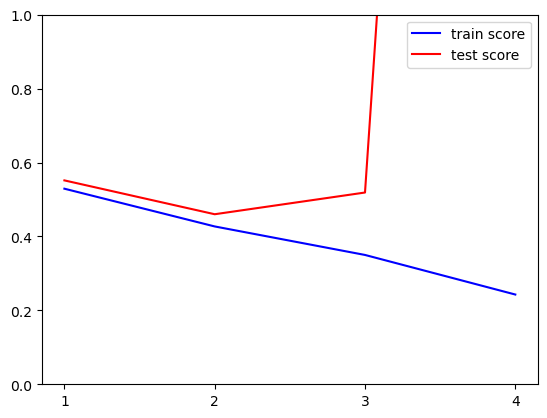

In [42]:


# inicializamos
degrees = np.array([1,2, 3, 4]) # Change degree "hyperparameter" here
mse_test  = np.zeros(len(degrees))
mse_train = np.zeros(len(degrees))
np.random.seed(0)

for degree in degrees:
	poly_features = PolynomialFeatures(degree = degree)
	X_train_poly = poly_features.fit_transform(X_train)
	X_test_poly = poly_features.fit_transform(X_test)
	polynomial_regressor = LinearRegression()
	polynomial_regressor.fit(X_train_poly, y_train)
        
	y_hat_train = polynomial_regressor.predict(X_train_poly)
	y_hat_test = polynomial_regressor.predict(X_test_poly)

    
	score_train= polynomial_regressor.score(X_train_poly,y_train)
	score_test= polynomial_regressor.score(X_test_poly,y_test)
    
	mse_train[np.where(degrees == degree)[0][0]] = 1 - score_train
	mse_test[np.where(degrees == degree)[0][0]]  = 1 - score_test
	
        
plt.plot(degrees, mse_train, 'b', label='train score')
plt.plot(degrees, mse_test, 'r', label='test score')
plt.ylim(0,1)
plt.xticks(degrees)
plt.legend()
plt.show()

In [43]:
#Mejor grado
best_degree = 2
poly_features = PolynomialFeatures(degree = best_degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)
best_polynomial_regressor = LinearRegression()
best_polynomial_regressor.fit(X_train_poly, y_train)
print(best_polynomial_regressor.score(X_train_poly, y_train))
print(best_polynomial_regressor.score(X_test_poly, y_test))


0.572952203096636
0.5399350036908672


In [44]:
df_scores = add_score(df_scores,["regresion_poliniomial",best_polynomial_regressor.score(X_train_poly, y_train),best_polynomial_regressor.score(X_test_poly, y_test)])

## knn-Neighbour

In [45]:
nVecinos =  list(range(1,25))
param_grid = {'n_neighbors':  nVecinos}
grid_KNeighborsRegressor = GridSearchCV(KNeighborsRegressor(p = 1), param_grid=param_grid,cv = 3,verbose=1)
grid_KNeighborsRegressor.fit(X_train, y_train)
grid_KNeighborsRegressor.score(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


0.6366144885255896

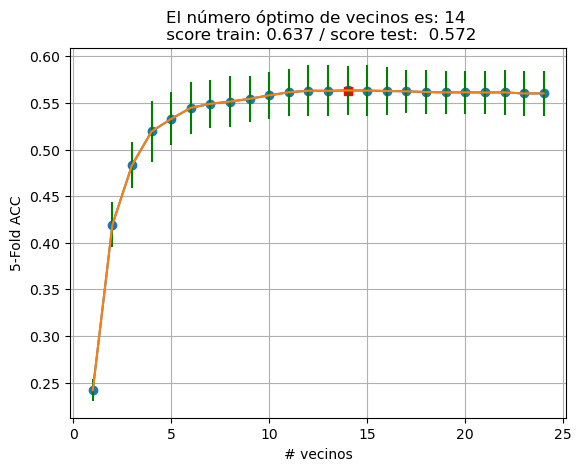

In [46]:
### Representación
nOpt = grid_KNeighborsRegressor.best_params_['n_neighbors']

scores = np.array(grid_KNeighborsRegressor.cv_results_['mean_test_score']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid_KNeighborsRegressor.cv_results_['std_test_score'])
plt.plot(nVecinos,scores,'-o')
plt.title('El número óptimo de vecinos es: %d \n score train: %0.3f / score test:  %0.3f' %  (nOpt , 
          																		grid_KNeighborsRegressor.score(X_train,y_train),
          																		grid_KNeighborsRegressor.score(X_test,y_test)))
plt.plot(nOpt,scores[nOpt],'rs')
plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()


In [47]:
df_scores = add_score(df_scores,["KNeighborsClassifier",grid_KNeighborsRegressor.score(X_train, y_train),grid_KNeighborsRegressor.score(X_test, y_test)])

## Lasso

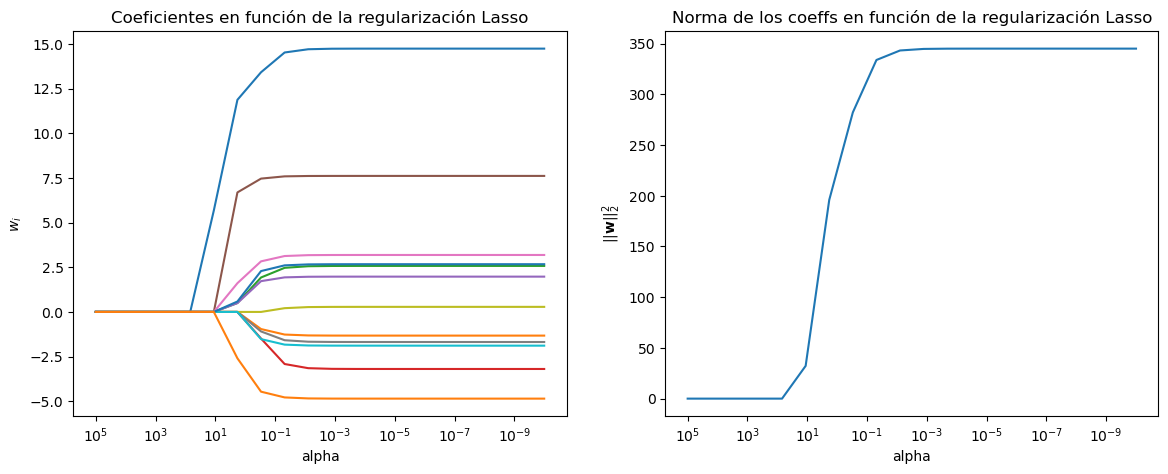

In [48]:
n_alphas = 20
alphas = np.logspace(-10,5, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    lasso = Lasso(alpha = a).fit(X_train,y_train)
    #####
    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización Lasso')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización Lasso')
plt.axis('tight')
plt.show()

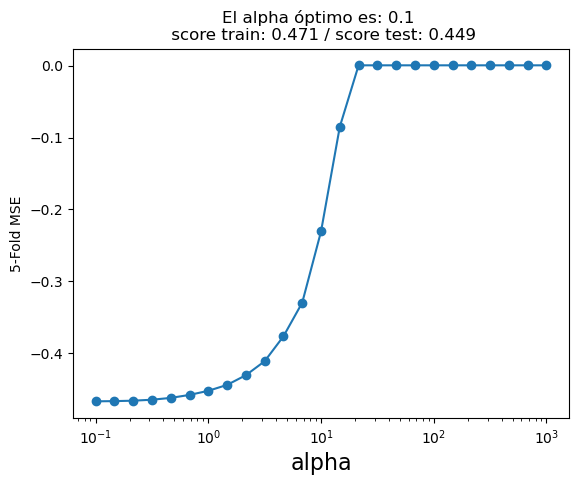

In [49]:
alpha_vector = np.logspace(-1,3,25)

grid_Lasso = GridSearchCV(Lasso(random_state=0), param_grid={'alpha': alpha_vector}, cv = 3)
grid_Lasso.fit(X_train, y_train)

# Representación
alpha_opt = grid_Lasso.best_params_['alpha']
scores = -1*np.array(grid_Lasso.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.title(f"El alpha óptimo es: {alpha_opt} \n score train: {round(grid_Lasso.score(X_train, y_train),3)} / score test: {round(grid_Lasso.score(X_test, y_test),3)}")
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [50]:
df_scores = add_score(df_scores,["Lasso",grid_Lasso.score(X_train, y_train),grid_Lasso.score(X_test, y_test)])

## Ridge

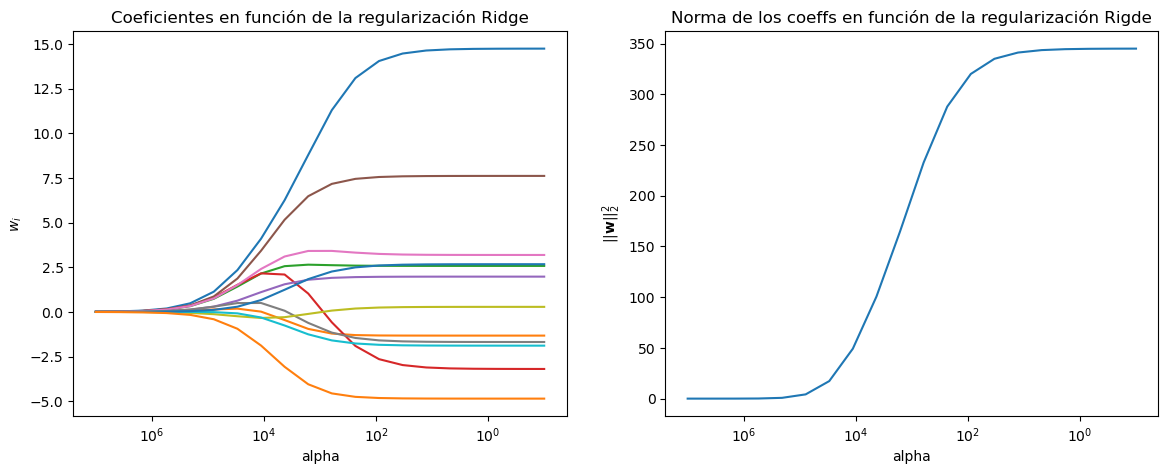

In [51]:
n_alphas = 20
alphas = np.logspace(7,-1, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    ridge = Ridge(alpha = a).fit(X_train,y_train)
    #####
    coefs.append(ridge.coef_)
    norm2_coefs.append(np.dot(ridge.coef_,ridge.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización Ridge')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización Rigde')
plt.axis('tight')
plt.show()


In [52]:
alpha_vector = np.logspace(7,-1,n_alphas)
grid_Rigde = GridSearchCV(Ridge(), param_grid={'alpha': alpha_vector }, cv = 3)
grid_Rigde.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e+07, 3.79269019e+06, 1.43844989e+06, 5.45559478e+05,
       2.06913808e+05, 7.84759970e+04, 2.97635144e+04, 1.12883789e+04,
       4.28133240e+03, 1.62377674e+03, 6.15848211e+02, 2.33572147e+02,
       8.85866790e+01, 3.35981829e+01, 1.27427499e+01, 4.83293024e+00,
       1.83298071e+00, 6.95192796e-01, 2.63665090e-01, 1.00000000e-01])})

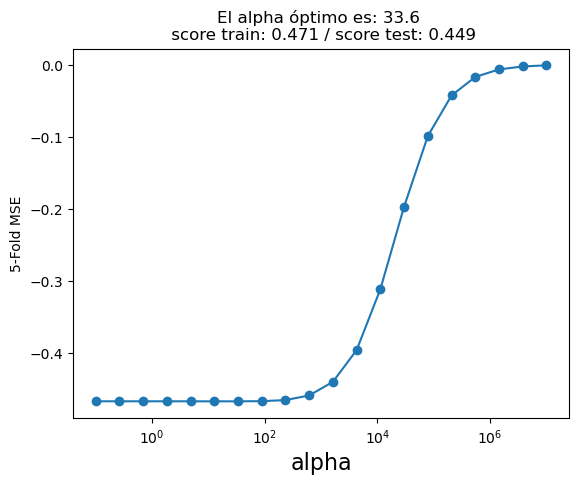

In [53]:
# Representación
alpha_opt = grid_Rigde.best_params_['alpha']
plt.title(f"El alpha óptimo es: {round(alpha_opt,2)} \n score train: {round(grid_Rigde.score(X_train, y_train),3)} / score test: {round(grid_Rigde.score(X_test, y_test),3)}")
scores = -1*np.array(grid_Rigde.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [54]:
df_scores = add_score(df_scores,["Ridge",grid_Rigde.score(X_train, y_train),grid_Rigde.score(X_test, y_test)])

## Árboles de decisión ( DecisionTreeRegressor )

Fitting 5 folds for each of 16 candidates, totalling 80 fits


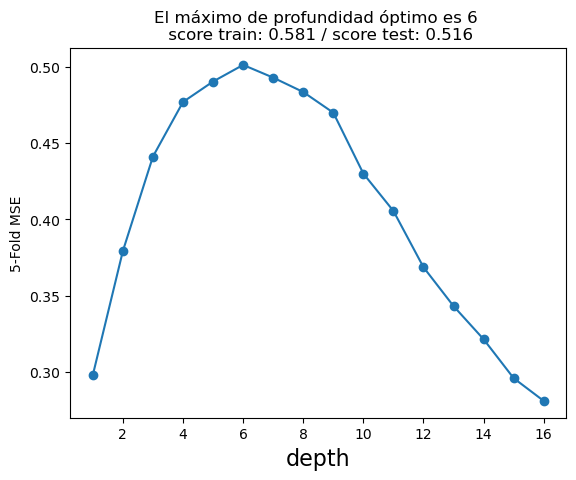

In [55]:
max_depth_vector = list(range(1,17))
param_grid = {'max_depth': max_depth_vector }
grid_DecisionTreeRegressor = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv = 5, verbose=1)
grid_DecisionTreeRegressor.fit(X_train, y_train)

max_depth_opt = grid_DecisionTreeRegressor.best_params_['max_depth']

model_DecisionTreeRegressor = DecisionTreeRegressor(max_depth = max_depth_opt)
model_DecisionTreeRegressor.fit(X_train, y_train)


scores = np.array(grid_DecisionTreeRegressor.cv_results_['mean_test_score'])
plt.title(f"El máximo de profundidad óptimo es {grid_DecisionTreeRegressor.best_params_['max_depth']} \n score train: {round(model_DecisionTreeRegressor.score(X_train, y_train),3)} / score test: {round(model_DecisionTreeRegressor.score(X_test, y_test),3)}")
plt.plot(max_depth_vector,scores,'-o')
plt.xlabel('depth',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [56]:
#Representación gráfica árbol de decisión
#dot_data = tree.export_graphviz(model_DecisionTreeRegressor, out_file=None, feature_names=features,filled=True, rounded=True,special_characters=True)
#graph = graphviz.Source(dot_data) 
#graph

In [57]:
df_scores = add_score(df_scores,["DecisionTreeRegressor",model_DecisionTreeRegressor.score(X_train, y_train),model_DecisionTreeRegressor.score(X_test, y_test)])

## Random Forest

Fitting 2 folds for each of 29 candidates, totalling 58 fits
best parameters: {'max_depth': 15}


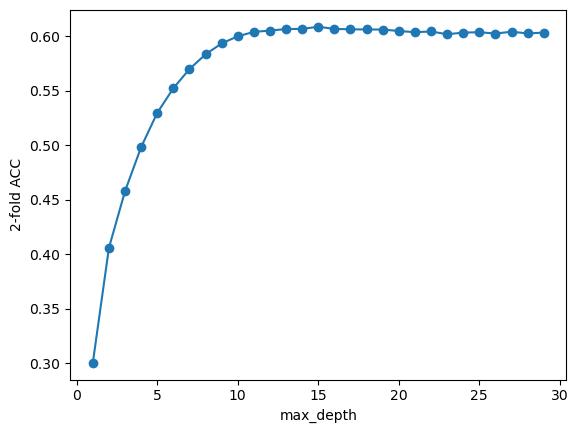

In [58]:
# Seleccionamos Profundidad(depth) adecuado para 
maxDepth = range(1,30)
#tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estimators}
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=2, verbose=1) 
grid.fit(X_train, y_train)

print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('2-fold ACC')

plt.show()

In [59]:
# grid search n_estimators
n_estimators = [50,250,500,750,1000,1500,2000]
tuned_parameters = {'max_depth': [15], 'n_estimators': n_estimators}

grid_RandomForestRegressor = GridSearchCV(RandomForestRegressor(random_state=0, max_features='sqrt'), param_grid=tuned_parameters,cv=2, verbose=1) 
grid_RandomForestRegressor.fit(X_train, y_train)


Fitting 2 folds for each of 7 candidates, totalling 14 fits


GridSearchCV(cv=2,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=0),
             param_grid={'max_depth': [15],
                         'n_estimators': [50, 250, 500, 750, 1000, 1500, 2000]},
             verbose=1)

In [60]:
n_estimators_opt = grid_RandomForestRegressor.best_params_['n_estimators']
modelo_RandomForestRegressor = RandomForestRegressor(random_state=0, n_estimators=n_estimators_opt,max_depth=12)
modelo_RandomForestRegressor.fit(X_train,y_train)
print("Train: ",modelo_RandomForestRegressor.score(X_train,y_train))
print("Test: ",modelo_RandomForestRegressor.score(X_test,y_test))

Train:  0.8464791554201173
Test:  0.6053491943136026


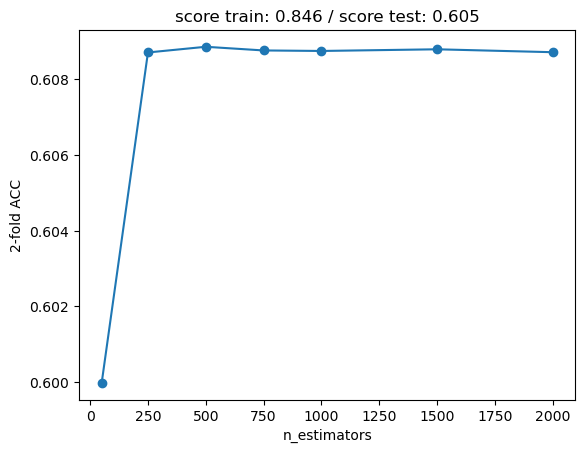

In [61]:
scores = np.array(grid_RandomForestRegressor.cv_results_['mean_test_score'])
plt.plot(n_estimators,scores,'-o')
plt.title(f"score train: {round(modelo_RandomForestRegressor.score(X_train,y_train),3)} / score test: {round(modelo_RandomForestRegressor.score(X_test,y_test),3)}")
plt.xlabel('n_estimators')
plt.ylabel('2-fold ACC')
plt.show()

In [62]:
df_scores = add_score(df_scores,["RandomForestRegressor",modelo_RandomForestRegressor.score(X_train, y_train),modelo_RandomForestRegressor.score(X_test, y_test)])

## Bagging

Fitting 2 folds for each of 14 candidates, totalling 28 fits
best mean cross-validation score: 0.593
best parameters: {'estimator__max_depth': 11}


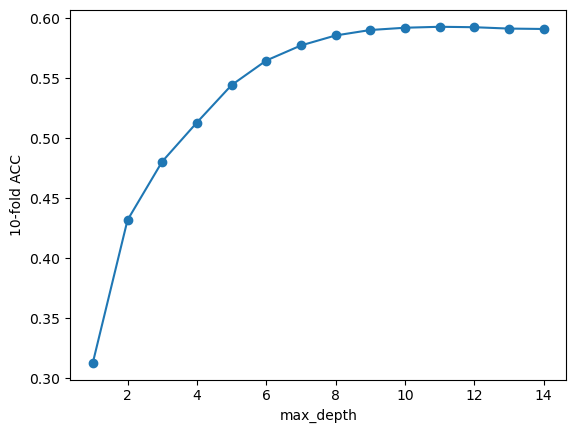

In [63]:
# grid search
maxDepth = range(1,15)
n_estimators = [100, 200, 300, 500, 1000, 1500, 2000]
#tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estimators}
tuned_parameters = {'estimator__max_depth': maxDepth}

grid = GridSearchCV(
    BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        random_state=0,
        n_estimators=200), 
    param_grid=tuned_parameters,
    cv=2,
    verbose=1
) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [64]:
n_estimators = [50,250,500,750,1000,1500,2000]
tuned_parameters = {'estimator__max_depth': [10], 'n_estimators': n_estimators}

grid_BaggingRegressor = GridSearchCV(
    BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        random_state=0), 
    param_grid=tuned_parameters,
    cv=2,
    verbose=1
) 
grid_BaggingRegressor.fit(X_train, y_train)
 

Fitting 2 folds for each of 7 candidates, totalling 14 fits


GridSearchCV(cv=2,
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor(),
                                        random_state=0),
             param_grid={'estimator__max_depth': [10],
                         'n_estimators': [50, 250, 500, 750, 1000, 1500, 2000]},
             verbose=1)

In [65]:
n_estimators_opt = grid_BaggingRegressor.best_params_['n_estimators']
modelo_BaggingRegressor = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),random_state=0, n_estimators=n_estimators_opt)
modelo_BaggingRegressor.fit(X_train,y_train)
print("Train: ",modelo_BaggingRegressor.score(X_train,y_train))
print("Test: ",modelo_BaggingRegressor.score(X_test,y_test))

Train:  0.7814482171367019
Test:  0.602737226857617


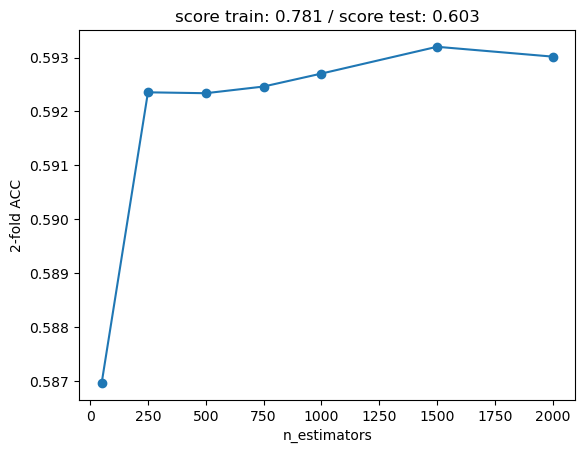

In [66]:
scores = np.array(grid_BaggingRegressor.cv_results_['mean_test_score'])
plt.plot(n_estimators,scores,'-o')
plt.title(f"score train: {round(modelo_BaggingRegressor.score(X_train,y_train),3)} / score test: {round(modelo_BaggingRegressor.score(X_test,y_test),3)}")
plt.xlabel('n_estimators')
plt.ylabel('2-fold ACC')
plt.show()

In [67]:
df_scores = add_score(df_scores,["BaggingRegressor",modelo_BaggingRegressor.score(X_train, y_train),modelo_BaggingRegressor.score(X_test, y_test)])

## GradientBoostingRegressor

In [68]:
Niterations = [100,250,500,1000]
learningRate = [0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid_GradientBoostingRegressor = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 2,verbose=1)
grid_GradientBoostingRegressor.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_GradientBoostingRegressor.best_score_))
print("best parameters: {}".format(grid_GradientBoostingRegressor.best_params_))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
best mean cross-validation score: 0.609
best parameters: {'learning_rate': 0.05, 'n_estimators': 500}


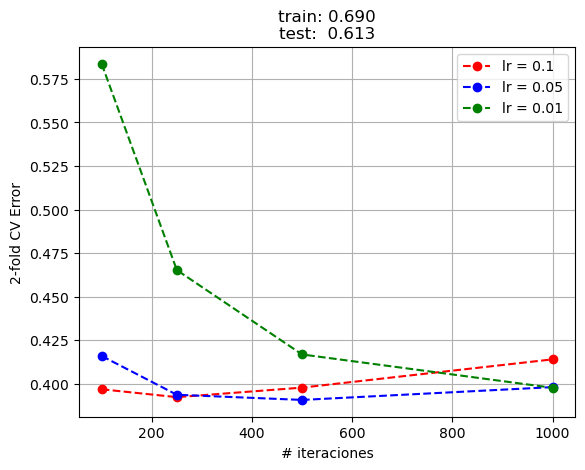

In [69]:
lrOptimo = grid_GradientBoostingRegressor.best_params_['learning_rate']
neOptimo = grid_GradientBoostingRegressor.best_params_['n_estimators']
model_GradientBoostingRegressor = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
model_GradientBoostingRegressor.fit(X_train,y_train)

error = 1-grid_GradientBoostingRegressor.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('2-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(model_GradientBoostingRegressor.score(X_train,y_train),model_GradientBoostingRegressor.score(X_test,y_test)))
plt.grid()
plt.show()

In [70]:
df_scores = add_score(df_scores,["GradientBoostingRegressor",model_GradientBoostingRegressor.score(X_train,y_train),model_GradientBoostingRegressor.score(X_test,y_test)])

## Xgboost

Fitting 2 folds for each of 19 candidates, totalling 38 fits
best mean cross-validation score: 0.600
best parameters: {'max_depth': 3}


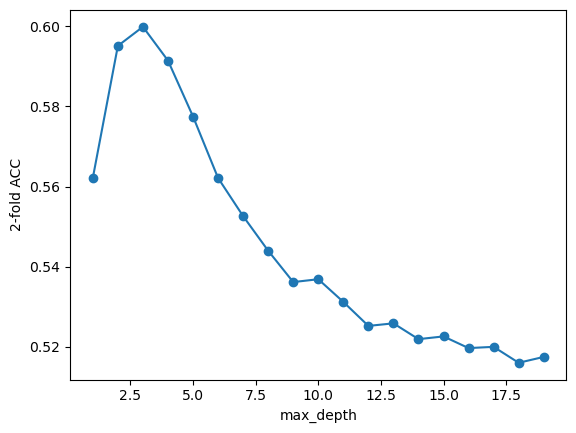

In [71]:
maxDepth = range(1,20)
#tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estimators}
param_grid = {'max_depth': maxDepth}

grid_XGBRegressor = GridSearchCV(XGBRegressor(random_state=0), param_grid=param_grid, cv = 2,verbose=1)
grid_XGBRegressor.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_XGBRegressor.best_score_))
print("best parameters: {}".format(grid_XGBRegressor.best_params_))

scores = np.array(grid_XGBRegressor.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('2-fold ACC')

plt.show()

In [72]:
Niterations = [100,250,500,1000]
learningRate = [0.1,0.05,0.01]


param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid_XGBRegressor = GridSearchCV(XGBRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 2,verbose=1)
grid_XGBRegressor.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_XGBRegressor.best_score_))
print("best parameters: {}".format(grid_XGBRegressor.best_params_))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
best mean cross-validation score: 0.610
best parameters: {'learning_rate': 0.05, 'n_estimators': 500}


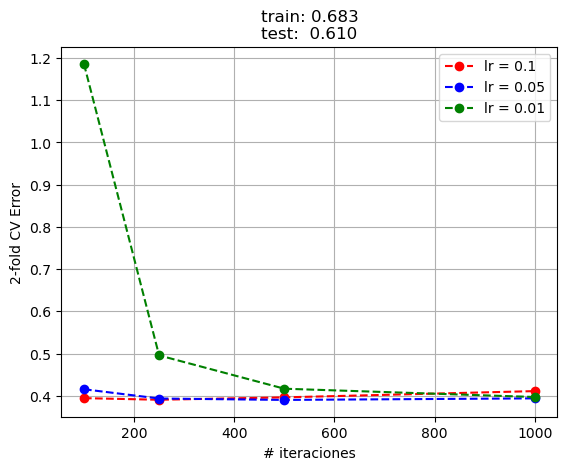

In [73]:
neOptimo = grid_XGBRegressor.best_params_['n_estimators']
lrOptimo = grid_XGBRegressor.best_params_['learning_rate']
model_XGBRegressor = XGBRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
model_XGBRegressor.fit(X_train,y_train)

error = 1-grid_XGBRegressor.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('2-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(model_XGBRegressor.score(X_train,y_train),model_XGBRegressor.score(X_test,y_test)))
plt.grid()
plt.show()

In [74]:
df_scores = add_score(df_scores,["XGBRegressor",model_XGBRegressor.score(X_train,y_train),model_XGBRegressor.score(X_test,y_test)])

## LightGBM

Fitting 5 folds for each of 29 candidates, totalling 145 fits
best mean cross-validation score: 0.627
best parameters: {'max_depth': 14}


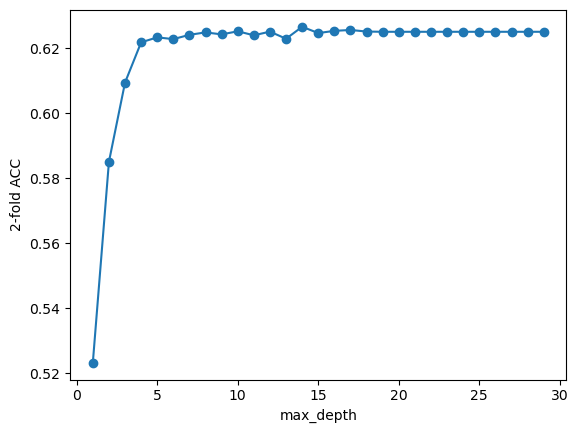

In [75]:
maxDepth = range(1,30)
#tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estimators}
param_grid = {'max_depth': maxDepth}

grid_LGBMRegressor = GridSearchCV(lgb.LGBMRegressor(random_state=0), param_grid=param_grid, cv = 5,verbose=1)
grid_LGBMRegressor.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_LGBMRegressor.best_score_))
print("best parameters: {}".format(grid_LGBMRegressor.best_params_))

scores = np.array(grid_LGBMRegressor.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('2-fold ACC')

plt.show()

In [76]:
Niterations = [25,50,100,250,500,1000]
learningRate = [0.1,0.05,0.01,0.001]


param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid_LGBMRegressor = GridSearchCV(lgb.LGBMRegressor(random_state=0, max_depth=14), param_grid=param_grid, cv = 2,verbose=1)
grid_LGBMRegressor.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid_LGBMRegressor.best_score_))
print("best parameters: {}".format(grid_LGBMRegressor.best_params_))

Fitting 2 folds for each of 24 candidates, totalling 48 fits
best mean cross-validation score: 0.613
best parameters: {'learning_rate': 0.1, 'n_estimators': 50}


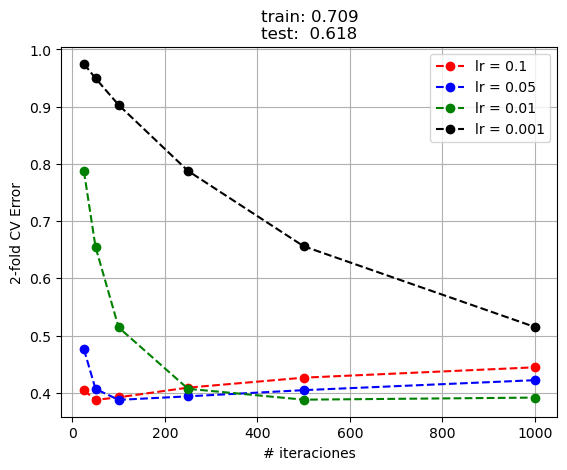

In [77]:
### lrOptimo = grid_GradientBoostingRegressor.best_params_['learning_rate']
neOptimo = grid_LGBMRegressor.best_params_['n_estimators']
lrOptimo = grid_LGBMRegressor.best_params_['learning_rate']
model_LGBMRegressor = lgb.LGBMRegressor(random_state=0, max_depth=7,learning_rate=lrOptimo, n_estimators=neOptimo)
model_LGBMRegressor.fit(X_train,y_train)

error = 1-grid_LGBMRegressor.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('2-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(model_LGBMRegressor.score(X_train,y_train),model_LGBMRegressor.score(X_test,y_test)))
plt.grid()
plt.show()

In [78]:
df_scores = add_score(df_scores,["LightGBM",model_LGBMRegressor.score(X_train,y_train),model_LGBMRegressor.score(X_test,y_test)])

## SVM

In [79]:
#Aplicamos logaritmo a la variable objetivo 
y_train_SVM = np.log10(y_train)
y_test_SVM = np.log10(y_test)

In [80]:
vectorC = [10]
vectorG = np.logspace(-1, 1, 2)
param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf',cache_size=4000), param_grid=param_grid, cv = 2, verbose=1)
grid.fit(X_train, y_train_SVM)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=SVR(cache_size=4000),
             param_grid={'C': [10], 'gamma': array([ 0.1, 10. ])}, verbose=1)

best mean cross-validation score: 0.514
best parameters: {'C': 10, 'gamma': 0.1}


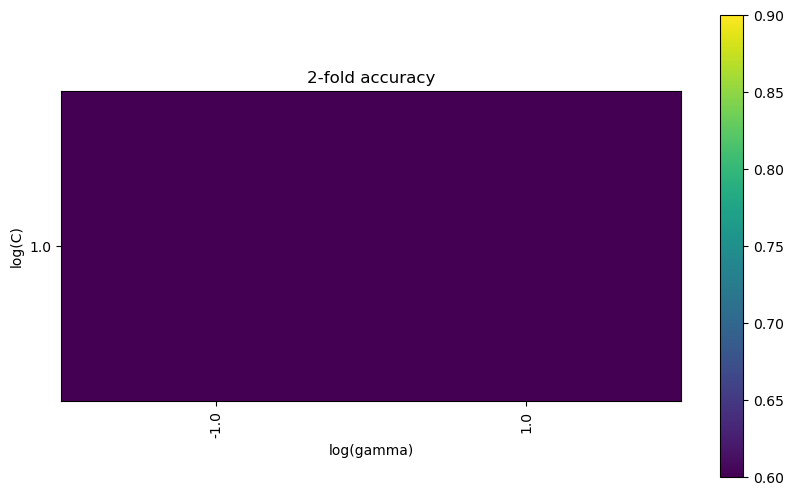

In [81]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('2-fold accuracy')
plt.show()

In [82]:
svr_rbf = SVR(kernel="rbf", C=10, gamma=0.1, epsilon=0.1,cache_size=4000).fit(X_train, y_train_SVM)

In [83]:
print(svr_rbf.score(X_train,y_train_SVM))
print(svr_rbf.score(X_test,y_test_SVM))

0.7508585932385364
0.5249389462281686


In [84]:
df_scores = add_score(df_scores,["SVR",svr_rbf.score(X_train,y_train_SVM),svr_rbf.score(X_test,y_test_SVM)])

## PCA

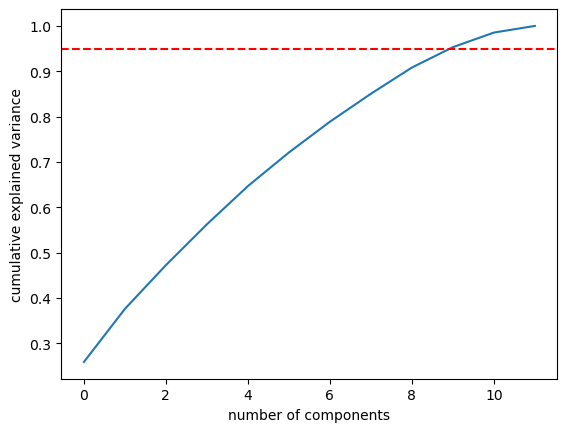

In [85]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, xmin=0, xmax=10,ls='dashed',color="red")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [86]:
pca=PCA(n_components=9)
pca.fit(X_train) 
X_train_pca=pca.transform(X_train) 
X_test_pca=pca.transform(X_test) 
print("shape of X_pca", X_train_pca.shape)
print("shape of X_pca", X_test_pca.shape)

shape of X_pca (6391, 9)
shape of X_pca (2620, 9)


In [87]:
#train PCR model on training data 
model_XGBRegressor = XGBRegressor(random_state=0, max_depth=3,learning_rate=0.05, n_estimators=500)
model_XGBRegressor.fit(X_train_pca,y_train)


print(model_XGBRegressor.score(X_train_pca,y_train))
print(model_XGBRegressor.score(X_test_pca,y_test))

0.6509883894648084
0.5335409169004512


In [88]:
df_scores = add_score(df_scores,["PCA+XGBRegressor",model_XGBRegressor.score(X_train_pca,y_train),model_XGBRegressor.score(X_test_pca,y_test)])

## Evaluación

In [89]:
from IPython.display import HTML
HTML(df_scores.to_html(index=False))

Modelo,Train_Score,Test_Score
regresion_lineal,0.470824,0.448364
regresion_poliniomial,0.572952,0.539935
KNeighborsClassifier,0.636614,0.571921
Lasso,0.470544,0.449492
Ridge,0.470794,0.448646
DecisionTreeRegressor,0.580556,0.516368
RandomForestRegressor,0.846479,0.605349
BaggingRegressor,0.781448,0.602737
GradientBoostingRegressor,0.690454,0.613208
XGBRegressor,0.683048,0.610342


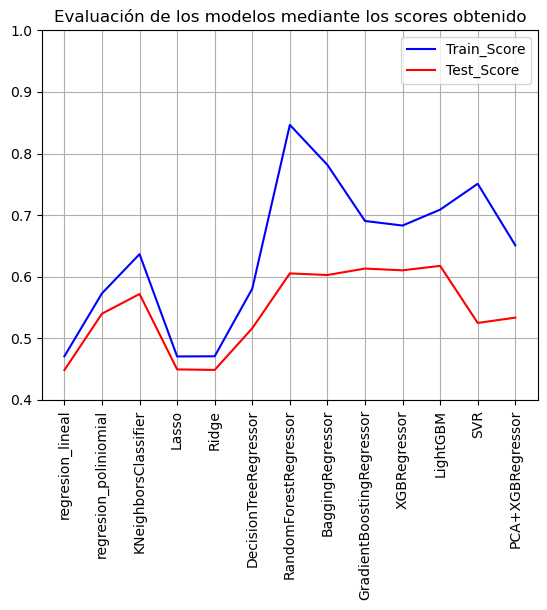

In [90]:
plot_scores(df_scores)

# 5. Conclusión: 

En esta práctica se ha realizado un ejemplo completo de machine learning pasando por todas las etapas que son:
 
1. Preparación de datos: División train/test
2. Análisis exploratorio
3. Preprocesamiento:
a. Eliminación de variables
- mediante selección (random forest/Lasso) 
- alta correlación
- alto porcentaje de missings
- análisis de características
b. Generación de variable
4. Modelado:
- Cross validation
- Evaluación

El dataset ha analizar contiene basta información pero con mucha inexactitud y con muchos datos incompletos , así que los modeloss obtenidos no son tan buenos como se cabría esperar.

El modelado ha sido desarrollado mediante una variedad de modelos de diferentes familias y se han obtenido resultados diversos dependiendo de la complejidad de los mismos.

He optado por tener una dimensionalidad de los datos baja y uso de hiperparámetros no muy extenso para poder tener un tiempo de ejecución aceptable.

La evaluación obtenida de los modelos ha sido muy diversa.

